In [1]:
import numpy as np
import re
import subprocess
import matplotlib.pyplot as plt
import matplotlib 
import astropy.units as u
from astropy.io import fits
from astropy.constants import m_p, M_sun

import os
gd_folder = os.getcwd()+"/../../Calculations/SKIRTOR/"

import sys 
sys.path.append(gd_folder)
#from loadSKIRTOR_MRN77 import LoadSKIRTOR_MRN77
from loadSKIRTOR_MRN77_force_reg import LoadSKIRTOR_MRN77
from loadSKIRTOR_General import LoadSKIRTOR_General

sys.path.append("../utility_functions/")
from objectProperties import ObjectProperties
from readExtrapolatedSpectra import ReadExtrapolatedSpectra

sys.path.append("../../Filter_Curves/")
from readBands import ReadBands

In [2]:
general_method_interp = "linear"
#general_method_interp = "pchip"

In [3]:
#Use the latex font when plotting. 
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [4]:
#Set the object ID.
wid = "W0204-0506"

In [5]:
#Load the object properties.
op = ObjectProperties([wid])

In [6]:
#Load the bands.
bands = ReadBands()
for bname in bands.bandnames:
    print(bname, bands.bp[bname].barlam(), bands.bp[bname].fwhm(), bands.bp[bname].rectwidth())

R_SPECIAL 6501.229535920617 Angstrom 1159.881393925198 Angstrom 1624.9974574790472 Angstrom
I_BESS 7925.773360798338 Angstrom 1080.5202412457434 Angstrom 1433.1539789444323 Angstrom
v_HIGH 5531.691038305597 Angstrom 850.6231300284223 Angstrom 1195.0838113345558 Angstrom


In [7]:
#Load the spectra for each BHD, extended using the best-fit SED.
specs = ReadExtrapolatedSpectra([wid])

Wavelength range for object W0019-1046 limited because of sky template
Spec-range: 3001.5 Angstrom - 5423.93 Angstrom
Sky-range: 3199.4 Angstrom - 6724.06 Angstrom
Wavelength range for object W0204-0506 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.70 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.
Wavelength range for object W0831+0140 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.45 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.


In [8]:
#Read the MRN77 chi2 map. 
p_map = dict()
chi2_map = dict()
pws = dict()
cone_types = ["Top", "Bottom"]
for cone_type in cone_types:
    pws[cone_type] = LoadSKIRTOR_MRN77(cone_type=cone_type, interp_method=general_method_interp)

pws_linear = dict()
for cone_type in cone_types:
    pws_linear[cone_type] = LoadSKIRTOR_MRN77(cone_type=cone_type, interp_method='linear')

bands_use = list()
p_meas = list()
p_unc = list()
for band in op.pfrac[wid].keys():
    bands_use.append(bands.bp[band])
    p_meas.append(op.pfrac[wid][band])
    p_unc.append(op.epfrac[wid][band])

chi2_map[wid] = dict()
for cone_type in cone_types:
    fname = "maps_{}Cone/chi2_map_{}.fits".format(cone_type, wid)
    h = fits.open(fname)
    tang_grid = np.array(h[0].header['TANGGRID'].split()).astype(float)
    tang_grid = tang_grid * u.Unit(h[0].header['TANGUNIT'])
    cang_grid = np.array(h[0].header['CANGGRID'].split()).astype(float)
    cang_grid = cang_grid * u.Unit(h[0].header['CANGUNIT'])
    iang_grid = np.array(h[0].header['IANGGRID'].split()).astype(float)
    iang_grid = iang_grid * u.Unit(h[0].header['IANGUNIT'])
    chi2_map[wid][cone_type] = np.ma.zeros((len(tang_grid), len(cang_grid), len(iang_grid)))
    chi2_map[wid][cone_type][:,:,:] = h[0].data
    chi2_map[wid][cone_type].mask = h[1].data.astype(bool)


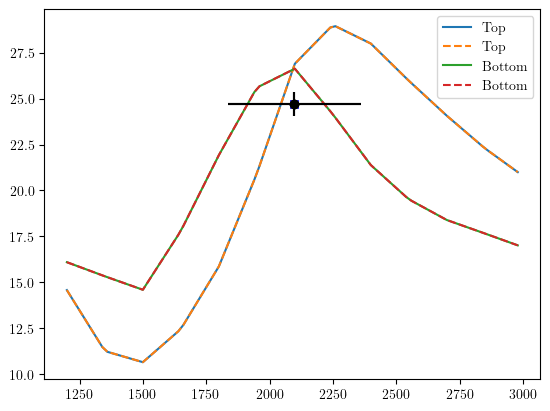

In [9]:
#Make a quick plot comparing linear and pchip interpolation. 
lam_grid = np.arange(1200., 3000., 20.)*u.AA

for cone_type in cone_types:
    i, j, k = np.unravel_index(np.argmin(chi2_map[wid][cone_type], axis=None), chi2_map[wid][cone_type].shape)
    plt.plot(lam_grid, 100*pws[cone_type].p((tang_grid[i]*np.ones(lam_grid.shape), cang_grid[j]*np.ones(lam_grid.shape), iang_grid[k]*np.ones(lam_grid.shape), lam_grid)), label=cone_type)
    plt.plot(lam_grid, 100*pws_linear[cone_type].p((tang_grid[i]*np.ones(lam_grid.shape), cang_grid[j]*np.ones(lam_grid.shape), iang_grid[k]*np.ones(lam_grid.shape), lam_grid)), label=cone_type, linestyle='dashed')

    for bname in op.pfrac[wid].keys():
        plt.errorbar([bands.bp[bname].barlam().value/(1+op.z[wid])], [op.pfrac[wid][bname]], xerr=[bands.bp[bname].rectwidth().value/2./(1+op.z[wid])], yerr=[op.epfrac[wid][bname]], marker='o', color='k')

        p_mod = pws[cone_type].p_bb(bands.bp[bname], tang_grid[i:i+1], cang_grid[j:j+1], iang_grid[k:k+1], specs.lam_obs[wid], specs.flam[wid], op.z[wid])
        plt.plot([bands.bp[bname].barlam().value/(1+op.z[wid])], [p_mod[0,0,0]*100], 'bx')

plt.legend()

In [ ]:
#Now, only do some selected models for the main Figure of the W0204-0506 paper. 
#Set the additional SKIRTOR models we want to plot for W0204-0506
other_sk_models = [

    #Draine (2003) models
    {"d03_mod":"MW" , "ls":'dotted', "label":"Draine (2003) Mixtures"},
    {"d03_mod":"LMC", "ls":'dotted', "label":None},
    {"d03_mod":"SMC", "ls":'dotted', "label":None},

    #MRN77_gra models
    # {"gs_min":0.005, "gs_max":0.25, "a":0.0, "ls":"dashed", "label":None},
    # {"gs_min":0.005, "gs_max":0.25, "a":2.0, "ls":"dashed", "label":None},
    # {"gs_min":0.005, "gs_max":0.25, "a":3.5, "ls":"dashed", "label":r"$\rm MRN77_{\rm gra}$"},

    #MRN77_gra+sil models
    {"gs_min":0.005, "gs_max":0.25, "a":3.5, "sil":True,"ls":"solid", "label":r'$\rm MRN77_{\rm gra+\rm sil}$'},

    #Large grain models gra only
    # {"gs_min":0.1, "gs_max":1, "a":0.0, "ls":"dotted", "label":"Large grains"},
    # {"gs_min":0.1, "gs_max":1, "a":0.5, "ls":"dotted", "label":"Large grains"},
    # {"gs_min":0.1, "gs_max":1, "a":1.5, "ls":"dotted", "label":"Large grains"},
    # {"gs_min":0.1, "gs_max":1, "a":2.5, "ls":"dotted", "label":"Large grains"},
    # {"gs_min":0.1, "gs_max":1, "a":3.5, "ls":"dotted", "label":"Large grains"},

    #Large grain models wit silicates.
    {"gs_min":0.1, "gs_max":1 , "a":3.5, "sil":True, "ls":"dashed", "label":None},
    {"gs_min":1  , "gs_max":10, "a":3.5, "sil":True, "ls":"dashed", "label":r"Large grains$_{\rm gra+\rm sil}$"},

    #Gaskell et al. (2004)
    #{"gs_min":0.005, "gs_max":0.2 , "a":2.05, "ls":(0, (3, 5, 1, 5, 1, 5)), "label":r"Gaskell et al. (2004)$_{\rm gra}$"},
    {"gs_min":0.005, "gs_max":0.2 , "a":2.05, "sil":True, "ls":"dashdot", "label":r"Gaskell et al. (2004)$_{\rm gra+\rm sil}$"},
    

]
other_sk = list()
other_chi2 = list()
for oskm in other_sk_models:
    oskm_obj_call = {k:v for k,v in oskm.items() if k not in ["ls","label"]}
    other_sk.append(LoadSKIRTOR_General(**oskm_obj_call, interp_method=general_method_interp))
    chi2_aux = np.zeros(len(iang_grid))
    for bname in op.pfrac[wid].keys():
        p_aux = other_sk[-1].p_bb(bands.bp[bname], iang_grid, specs.lam_obs[wid], specs.flam[wid], specs.specs.sp[wid].zspec)
        chi2_aux += ((p_aux*100 - op.pfrac[wid][bname])/op.epfrac[wid][bname])**2
    other_chi2.append(chi2_aux)
